### Denoising Images using Autoencoders
This notebook will be demonstrating denoising process of an image dataset ( cifar10 in this case) using an Autoencoder model.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as Datasets
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import multiprocessing as mp
from torch.utils.tensorboard import SummaryWriter
import math
from random import randint

In [2]:
#  configuring device
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print('Running on the GPU')
else:
    device = torch.device('cpu')
    print('Running on the CPU')

Running on the GPU


In [3]:
#  Adding gaussian noise

class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0, 0, 0], [1, 1, 1])
])

transform_noisy = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0, 0, 0], [1, 1, 1]),
    AddGaussianNoise(0., 0.2)
])


In [4]:
#  Calling datsets and and defining Dataloaders for the training and testing models
n_cpus = mp.cpu_count()


trainset = Datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=n_cpus,pin_memory=True)
testset = Datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = DataLoader(testset, batch_size=32,
                                         shuffle=False, num_workers=n_cpus,pin_memory=True)

trainset_noisy = Datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_noisy)
trainloader_noisy = DataLoader(trainset_noisy, batch_size=32,
                                          shuffle=True, num_workers=n_cpus,pin_memory=True)
testset_noisy = Datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_noisy)
testloader_noisy = DataLoader(testset_noisy, batch_size=32,
                                         shuffle=False, num_workers=n_cpus,pin_memory=True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [26]:
class_names = trainset.classes
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [27]:
# Check the shape of our image
print(f"Image shape: {image.shape} -> [color_channels, height, width]") 
print(f"Image label: {class_names[label]}")

Image shape: torch.Size([3, 32, 32]) -> [color_channels, height, width]
Image label: frog


In [5]:
len(trainset),len(testset),

(50000, 10000)

In [6]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [7]:
class EarlyStopper:
    def __init__(self, patience=1, tolerance=0):
       # How many epochs in a row the model is allowed to underperform
        self.patience = patience
       # How much leeway the model has (i.e. how close it can get to underperforming before it is counted as such)
        self.tolerance = tolerance
       # Keeping track of how many epochs in a row were failed
        self.epoch_counter = 0
       # Keeping track of best metric so far
        self.max_validation_acc = np.NINF

    def should_stop(self, validation_acc):
        if validation_acc > self.max_validation_acc:
            self.max_validation_acc = validation_acc
            self.epoch_counter = 0
        elif validation_acc < (self.max_validation_acc - self.tolerance):
            self.epoch_counter += 1
            if self.epoch_counter >= self.patience:
                return True

        return False

In [8]:
import os


# Saves a model to file, and names it after the current epoch
def save_checkpoint(model, epoch, save_dir):
    filename = f"checkpoint_{epoch}.pt"
    save_path = os.path.join(save_dir, filename)
    torch.save(model, save_path)

In [9]:
from torch.optim.lr_scheduler import ExponentialLR
def train(model, trainloader, optimizer, criterion, device, idx,lr_scheduler, stopper,writer,checkpoint_frequency):
  model.train()
  model.to(device)

  train_loss_avg = 0.0
  for batch_index, batch in enumerate(trainloader):
    x_batch, _ = batch

    x_batch = x_batch.to(device)

    optimizer.zero_grad()

    y_pred = model(x_batch)

    loss = criterion(y_pred, x_batch)
    loss.backward()

    optimizer.step()

    train_loss_avg += loss.item()

  train_loss_avg /= (batch_index + 1)

  return  train_loss_avg

In [10]:
def validate(model, testloader, optimizer, criterion, device, idx,lr_scheduler,stopper, writer,checkpoint_frequency):
  model.eval()
  model.to(device)

  val_loss_avg = 0.0
  for batch_index, batch in enumerate(testloader):
    x_batch, _ = batch

    x_batch = x_batch.to(device)

    optimizer.zero_grad()

    y_pred = model(x_batch)

    loss = criterion(y_pred, x_batch)

    val_loss_avg += loss.item()

  val_loss_avg /= (batch_index + 1)

  return  val_loss_avg

In [11]:
def plot_metrics(index, model_name, train_loss, val_loss):
  axis[index].set_title(f'{model_name}\nTraining Validation Loss')
  axis[index].plot(train_loss,  marker='o', label="Training Loss")
  axis[index].plot(val_loss,  marker='o', label="Validation Loss")
  axis[index].set(xlabel='Epoch', ylabel='Loss')
  axis[index].legend()

In [16]:
#Define the Convolutional Autoencoder
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
       
        #Encoder
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)  
        self.conv2 = nn.Conv2d(16, 4, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
       
        #Decoder
        self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(16, 3, 2, stride=2)


    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.t_conv1(x))
        x = F.sigmoid(self.t_conv2(x))
              
        return x

Training model:  ConvAutoencoder
Epoch:   1 | train_loss: 0.020939 | val_loss: 0.017328
Epoch:   2 | train_loss: 0.013273 | val_loss: 0.010816
Epoch:   3 | train_loss: 0.010496 | val_loss: 0.010314
Epoch:   4 | train_loss: 0.010139 | val_loss: 0.010068
Epoch:   5 | train_loss: 0.009917 | val_loss: 0.009868
Epoch:   6 | train_loss: 0.009788 | val_loss: 0.009772
Epoch:   7 | train_loss: 0.009707 | val_loss: 0.009687
Epoch:   8 | train_loss: 0.009648 | val_loss: 0.009637
Epoch:   9 | train_loss: 0.009597 | val_loss: 0.009603
Epoch:  10 | train_loss: 0.009549 | val_loss: 0.009509
Epoch:  11 | train_loss: 0.009481 | val_loss: 0.009477
Epoch:  12 | train_loss: 0.009428 | val_loss: 0.009427
Epoch:  13 | train_loss: 0.009396 | val_loss: 0.009388
Epoch:  14 | train_loss: 0.009369 | val_loss: 0.009404
Epoch:  15 | train_loss: 0.009345 | val_loss: 0.009407
Epoch:  16 | train_loss: 0.009328 | val_loss: 0.009363
Epoch:  17 | train_loss: 0.009312 | val_loss: 0.009344
Epoch:  18 | train_loss: 0.00930

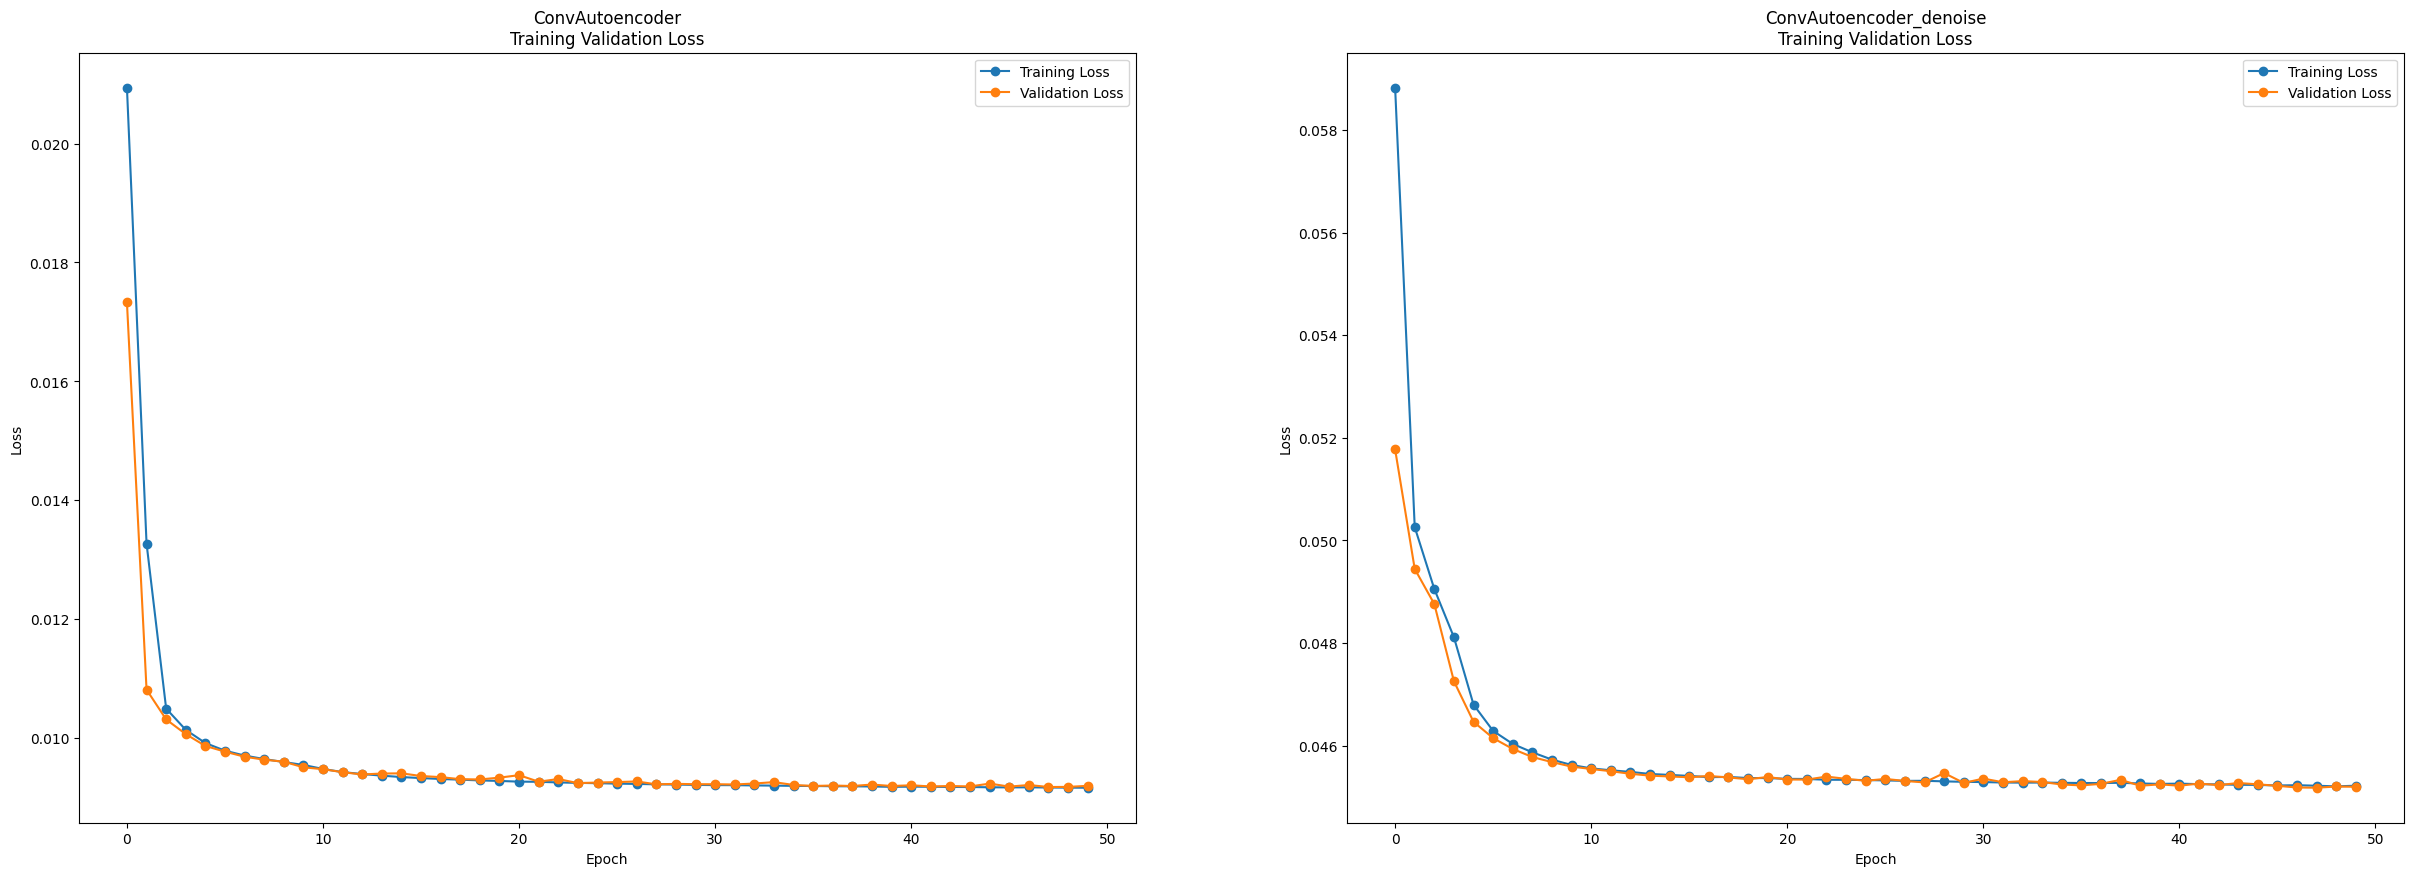

In [20]:
#  Training process

runs = 2
figure, axis = plt.subplots(1, 2, figsize=(30, 10))

for idx in range(runs):
  start = time.time()

  if idx == 0:
    model = ConvAutoencoder()
    model_name = 'ConvAutoencoder'
    train_load = trainloader
    test_load = testloader
  elif idx == 1:
    model = ConvAutoencoder()
    model_name = 'ConvAutoencoder_denoise'
    train_load = trainloader_noisy
    test_load = testloader_noisy
  
  print('Training model: ', model_name)
#   print(model)

  model_save_path = os.path.join(os.getcwd(), model_name + '.pt')

  epochs = 50
  lr = 1e-3
  criterion = nn.MSELoss()
  optimizer = optim.Adam(model.parameters(), lr=lr)
  lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1)
  # Instantiate summary writer
  writer = SummaryWriter()
  # Instantiate early stopper with patience=3 and tolerance=0
  stopper = EarlyStopper(patience=3, tolerance=0)
  checkpoint_frequency = 3
    
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  train_loss_list = []
  val_loss_list = []
  lowest_loss = np.Inf
    
    

  for epoch in range(epochs):
    train_loss = train(model, train_load, optimizer, criterion, device, idx,lr_scheduler, writer,stopper,checkpoint_frequency)
    train_loss_list.append(train_loss)

    val_loss = validate(model, test_load, optimizer, criterion, device, idx,lr_scheduler, writer,stopper,checkpoint_frequency)
    val_loss_list.append(val_loss)

    if val_loss < lowest_loss:
      torch.save(model.state_dict(), model_save_path)
    

    print('Epoch: {0:3d} | train_loss: {1:2f} | val_loss: {2:2f}'.format(epoch + 1, train_loss, val_loss))

  end = time.time()

  print(f'{model_name} model total training-validation time: {(end-start) / 60} minutes\n')

  plot_metrics(idx, model_name, train_loss_list, val_loss_list)

--------------------------------
ConvAutoencoder input images



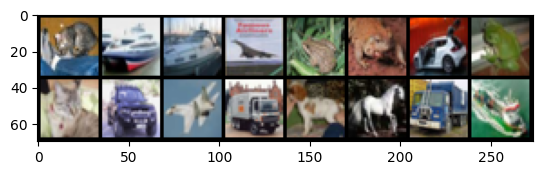

ConvAutoencoder output/reconstructed images



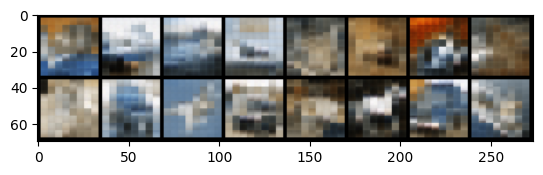

--------------------------------



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


--------------------------------
ConvAutoencoder_denoise input images



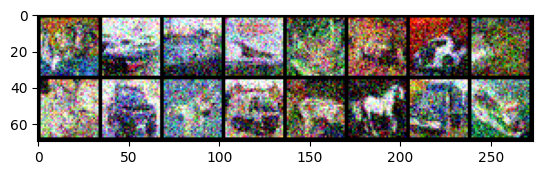

ConvAutoencoder_denoise output/reconstructed images



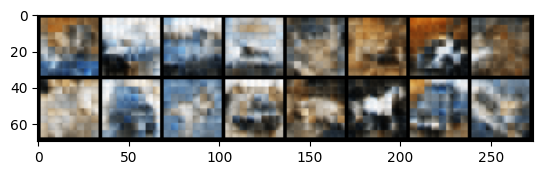

--------------------------------



In [39]:
#  Image comparison after denoising.

runs = 2

for idx in range(runs):
  if idx == 0:
    model = ConvAutoencoder()
    model.load_state_dict(torch.load('ConvAutoencoder.pt'))
    model_name = 'ConvAutoencoder'
    test_load = DataLoader(testset, batch_size=16,
                                         shuffle=False, num_workers=n_cpus,pin_memory=True)
  elif idx == 1:
    model = ConvAutoencoder()
    model.load_state_dict(torch.load('ConvAutoencoder_denoise.pt'))
    model_name = 'ConvAutoencoder_denoise'
    test_load = DataLoader(testset_noisy, batch_size=16,
                                         shuffle=False, num_workers=n_cpus,pin_memory=True)

  dataiter = iter(test_load)
  images, _ = next(dataiter)

  model.eval()
  model.to(device)

  images = images.to(device)

  # Get predictions from model
  y_pred = model(images)

  print('--------------------------------')
  print(model_name, 'input images\n')

  # Print ground truth images
  imshow(torchvision.utils.make_grid(images.cpu()))

  print(model_name, 'output/reconstructed images\n')

  # Print predicted/reconstructed images
  imshow(torchvision.utils.make_grid(y_pred.cpu()))

  print('--------------------------------\n')